In [1]:
%env ASTERIA=/home/jakob/software/ASTERIA/ASTERIA

from asteria.simulation import Simulation
from analysis import *

import matplotlib.pyplot as plt

env: ASTERIA=/home/jakob/software/ASTERIA/ASTERIA


In [2]:
include_wls = False

trials = 10000
distance = 5*u.kpc
frequency = 400*u.Hz # 50 Hz and 400 Hz, in steps of 50 Hz
amplitude = 0.2 # 1% and 50% in log steps (1%, 2%, 5%, 10%, 20%, 50%)
time_start = 200*u.ms
time_end = 300*u.ms
position="center"

sim_dt = 1 * u.ms
res_dt = 1 * u.ms
time_win = [0, 100] * u.s # time independent
freq_res = 1 * u.Hz 
freq_win = [1, 1E6] * u.Hz # freq independent

hann_len = 50*u.ms # length of Hann window
hann_res = 5*u.Hz # relates to frequency resolution from hanning, mfft = freq_sam/freq_sam
hann_hop = 10*u.ms # offset by which Hann window is slided over signal
freq_sam = (1/res_dt).to(u.Hz) # = 1/time_res

temp_para = {"frequency": frequency, 
             "amplitude": amplitude, #in percent of max value
             "time_start": time_start,
             "time_end": time_end,
             "position": position}

fft_para = {"time_res": res_dt, 
             "time_win": time_win,
             "freq_res": time_start,
             "freq_win": freq_win}

stf_para = {"hann_len": hann_len,
             "hann_res": hann_res,
             "hann_hop": hann_hop, 
             "freq_sam": freq_sam}


model = {'name': 'Sukhbold_2015',
         'param':{
             'progenitor_mass': 9.6*u.Msun, 
             'eos': 'LS220'}
        }

sim = Simulation(model=model,
                 distance=10* u.kpc, 
                 res_dt=res_dt,
                 Emin=0*u.MeV, Emax=100*u.MeV, dE=1*u.MeV,
                 tmin=0.000*u.s, tmax=1.000*u.s, dt=sim_dt,
                 hierarchy = 'normal',
                 mixing_scheme = 'NoTransformation',
                 geomscope = 'Gen2',
                 include_wls = include_wls)
sim.run()



In [3]:
# Initialize analysis class and run analysis
ana = Analysis(sim, res_dt = res_dt, distance=distance, trials = trials, temp_para=temp_para)
ana.run(fft_para, stf_para, mode = "STF")


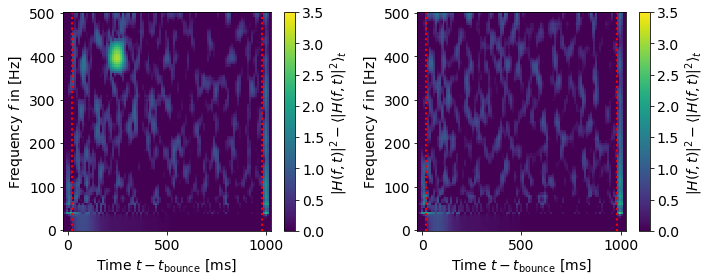

In [4]:
fig, ax = plt.subplots(1,2, figsize = (10,4))

hypos = ["signal", "null"]
im, cb = [None,None], [None,None]

for i in range(2):
    im[i] = ax[i].pcolor(ana.stf_time_edge, ana.stf_freq_edge, ana._log[hypos[i]]["ic86"][0], cmap='viridis', vmin = 0, vmax = 3.5)
    ax[i].axvline(20, color = "r", ls = ":", lw = 2)
    ax[i].axvline(980, color = "r", ls = ":", lw = 2)

    cb = fig.colorbar(im[i])
    cb.ax.tick_params(labelsize=14)
    cb.set_label(label=r"$|H(f,t)|^2 - \langle |H(f,t)|^2 \rangle_t$",size=14)
    ax[i].set_xlabel(r'Time $t-t_{\rm bounce}$ [ms]', fontsize=14)
    ax[i].set_ylabel(f"Frequency $f$ in [Hz]", fontsize=14)
    ax[i].yaxis.get_offset_text().set_fontsize(14)
    ax[i].tick_params(labelsize=14)

plt.tight_layout()

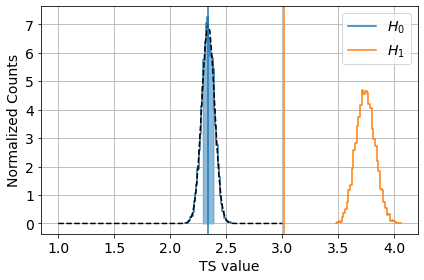

In [6]:
# Plot TS distribution for null and signal hypothesis for gen2

bins = 40

# histogram TS distribution of null and signal hypothesis for gen2 
y_signal, bins_signal = np.histogram(ana.stf_ts["signal"]["gen2"], bins = bins, density = True)
y_null, bins_null = np.histogram(ana.stf_ts["null"]["ic86"], bins = bins, density = True)

# get x values
x_signal = (bins_signal[:-1]+bins_signal[1:])/2
x_null = (bins_null[:-1]+bins_null[1:])/2

# get fitted background distribution
x_fit = np.linspace(1, 3, 100)
y_fit = ana._ts_bkg_fit_ic86.pdf(x_fit)

# mask range of 16% and 84% quantiles
mask_signal = np.logical_and(x_signal > ana.ts_stat["signal"]["ic86"][1], x_signal < ana.ts_stat["signal"]["ic86"][2])
mask_null = np.logical_and(x_null > ana.ts_stat["null"]["ic86"][1], x_null < ana.ts_stat["null"]["ic86"][2])

fig, ax = plt.subplots(1,1)

ax.step(x_null, y_null, where = "mid", label = r"$H_0$")
ax.step(x_signal, y_signal, where = "mid", label = r"$H_1$")
ax.plot(x_fit, y_fit, "k--")

ax.axvline(ana.ts_stat["signal"]["ic86"][0], ymin = 0, ymax =np.max(y_signal), color = 'C1', ls = '-')
ax.axvline(ana.ts_stat["null"]["ic86"][0], ymin = 0, ymax =np.max(y_null), color = 'C0', ls = '-')
ax.fill_between(x = x_signal[mask_signal], y1 = y_signal[mask_signal], color = 'C1', alpha = 0.5)
ax.fill_between(x = x_null[mask_null], y1 = y_null[mask_null], color = 'C0', alpha = 0.5)


ax.set_xlabel("TS value", fontsize = 14)
ax.set_ylabel("Normalized Counts", fontsize = 14)
ax.tick_params(labelsize = 14)
ax.grid()
ax.legend(fontsize = 14)

plt.tight_layout()

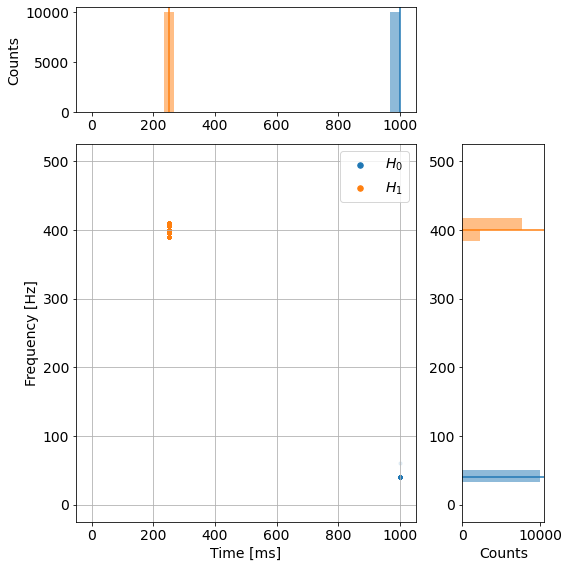

In [7]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# Data
fit_freq_null, fit_time_null = ana.stf_fit_freq["null"]["ic86"], ana.stf_fit_time["null"]["ic86"]
fit_freq_signal, fit_time_signal = ana.stf_fit_freq["signal"]["ic86"], ana.stf_fit_time["signal"]["ic86"]

fig = plt.figure(figsize=(8, 8))
gs = fig.add_gridspec(4, 4)

# Main scatter plot
ax_main = fig.add_subplot(gs[1:, :-1])
ax_main.scatter(fit_time_null, fit_freq_null, s=10, alpha=0.1, color="C0", label=r"$H_0$")
ax_main.scatter(fit_time_signal, fit_freq_signal, s=10, alpha=0.1, color="C1", label=r"$H_1$")
ax_main.set_xlabel("Time [ms]", fontsize=14)
ax_main.set_ylabel("Frequency [Hz]", fontsize=14)
ax_main.tick_params(labelsize=14)
ax_main.grid()

# Top histogram
ax_top = fig.add_subplot(gs[0, :-1], sharex=ax_main)
ax_top.hist(fit_time_null, bins=30, range = (0, 1000), alpha=0.5, color="C0", orientation='vertical')
ax_top.hist(fit_time_signal, bins=30, range = (0, 1000), alpha=0.5, color="C1", orientation='vertical')
ax_top.axvline(np.median(fit_time_null), color="C0")
ax_top.axvline(np.median(fit_time_signal), color="C1")

ax_top.set_ylabel("Counts", fontsize=14)
ax_top.tick_params(labelsize=14)

# Right histogram
ax_right = fig.add_subplot(gs[1:, -1], sharey=ax_main)
ax_right.hist(fit_freq_null, bins=30, range = (0, 500), alpha=0.5, color="C0", orientation='horizontal')
ax_right.hist(fit_freq_signal, bins=30, range = (0, 500), alpha=0.5, color="C1", orientation='horizontal')
ax_right.axhline(np.median(fit_freq_null), color="C0")
ax_right.axhline(np.median(fit_freq_signal), color="C1")
ax_right.set_xlabel("Counts", fontsize=14)
ax_right.tick_params(labelsize=14)

# Adjusting legend handles
leg = ax_main.legend(fontsize=14)
for h in leg.legend_handles:
    h.set_alpha(1)  # Set legend handle opacity to 1 (opaque)
    h.set_sizes([30])  # Set legend handle size to 30

plt.tight_layout()
plt.show()

In [8]:
dist_range = np.arange(2,20,2) * u.kpc
Zscore, Ts_stat = ana.dist_scan(dist_range, fft_para, stf_para, mode="STF")

Distance: 2.0 kpc
Distance: 4.0 kpc
Distance: 6.0 kpc
Distance: 8.0 kpc
Distance: 10.0 kpc
Distance: 12.0 kpc
Distance: 14.0 kpc
Distance: 16.0 kpc
Distance: 18.0 kpc


/tmp/ipykernel_30645/453993916.py:34: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return float(diff)
/tmp/ipykernel_30645/453993916.py:34: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return float(diff)
/tmp/ipykernel_30645/453993916.py:34: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return float(diff)
/tmp/ipykernel_30645/453993916.py:34: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you e

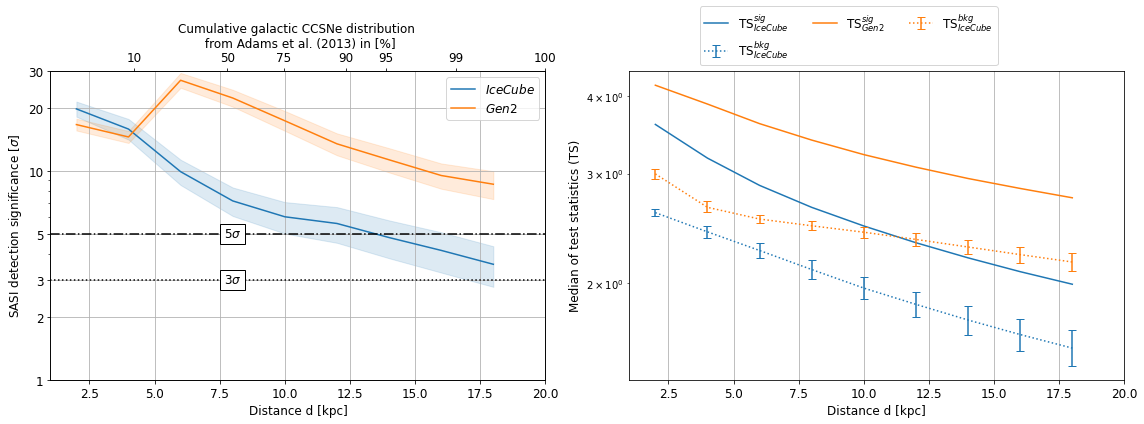

In [13]:
fig, ax = plt.subplots(1,2, figsize = (16,6))
ax = ax.ravel()

ax[0].plot(dist_range, Zscore["ic86"][0], color = 'C0', label=r'$IceCube$')
ax[0].plot(dist_range, Zscore["gen2"][0], color = 'C1', label=r'$Gen2$')

ax[0].fill_between(dist_range.value, Zscore["ic86"][2], Zscore["ic86"][1], alpha = 0.15, color = 'C0')
ax[0].fill_between(dist_range.value, Zscore["gen2"][2], Zscore["gen2"][1], alpha = 0.15, color = 'C1')

ax[0].set_xlabel('Distance d [kpc]', fontsize = 12)
ax[0].set_ylabel(r'SASI detection significance [$\sigma$]' , fontsize = 12)
ax[0].set_xlim((1,20))
ax[0].set_ylim((1,30))

ax[0].tick_params(labelsize = 12)

ax[0].set_yscale('log')
ax[0].set_yticks([1,2,3,5,10,20,30])
ax[0].set_yticklabels(['1','2','3','5','10','20','30'])

ax[0].grid()
ax[0].legend(loc='upper right', fontsize = 12)

ax[0].axhline(3, color='k', ls = ':')
ax[0].axhline(5, color='k', ls = '-.')
ax[0].text(8, 3, r"3$\sigma$", size=12,
         ha="center", va="center",
         bbox=dict(boxstyle="square", ec='k', fc='white'))

ax[0].text(8, 5, r"5$\sigma$", size=12,
         ha="center", va="center",
         bbox=dict(boxstyle="square", ec='k', fc='white'))

rates = np.array([0.1,0.5,0.75,0.9,0.95,0.99,1])
ax22 = ax[0].twiny()
ax22.set_xlim(ax[0].get_xlim())
ax22.set_xticks(inv_cdf(rates).flatten())
ax22.set_xticklabels((rates*100).astype(dtype=int), rotation = 0, fontsize = 12)
ax22.set_xlabel('Cumulative galactic CCSNe distribution \n from Adams et al. (2013) in [%]', fontsize = 12)

#signal without errorbar
ax[1].plot(dist_range, Ts_stat["signal"]["ic86"][0], color = 'C0', label=r'TS$^{sig}_{IceCube}$')
ax[1].plot(dist_range, Ts_stat["signal"]["gen2"][0], color = 'C1', label=r'TS$^{sig}_{Gen2}$')

#background with errorbar
ax[1].errorbar(x = dist_range, y = Ts_stat["null"]["ic86"][0],
               yerr = (Ts_stat["null"]["ic86"][0]-Ts_stat["null"]["ic86"][1],Ts_stat["null"]["ic86"][2]-Ts_stat["null"]["ic86"][0]), 
               capsize=4, color = 'C0', ls = ':', label=r'TS$^{bkg}_{IceCube}$')
ax[1].errorbar(x = dist_range, y = Ts_stat["null"]["gen2"][0],
               yerr = (Ts_stat["null"]["gen2"][0]-Ts_stat["null"]["gen2"][1],Ts_stat["null"]["gen2"][2]-Ts_stat["null"]["gen2"][0]), 
               capsize=4, color = 'C1', ls = ':', label=r'TS$^{bkg}_{IceCube}$')
#rearrange legend handels
handles,labels = ax[1].get_legend_handles_labels()

#handles = [handles[0], handles[3], handles[1], handles[4], handles[2], handles[5]]
#labels = [labels[0], labels[3], labels[1], labels[4], labels[2], labels[5]]

handles = [handles[0], handles[2], handles[1], handles[3]]
labels = [labels[0], labels[2], labels[1], labels[3]]


ax[1].set_xlabel('Distance d [kpc]', fontsize = 12)
ax[1].set_ylabel('Median of test statistics (TS)', fontsize = 12)
ax[1].set_xlim((1,20))
ax[1].set_yscale('log')
ax[1].tick_params(labelsize = 12)
ax[1].legend(handles, labels, ncol = 3, fontsize = 12, bbox_to_anchor=(0.13, 1))
ax[1].grid()

plt.tight_layout()

#filename = './plots/bj_'+smodel+'_dir='+str(sdir)+'_mix='+smix+'_hierarchy='+shier+'_time'+stime+'_freq'+sfreq+'_IC86+Gen2+WLS.png'
#plt.savefig(filename, dpi = 200, facecolor = 'white')

In [10]:
import os
from asteria.stellardist import StellarDensity
from scipy.interpolate import PchipInterpolator
from scipy.optimize import minimize

def diff(x, r):
    diff = np.abs(Dist2Rate(x) - r)
    return float(diff)

def Dist2Rate(d):
    return sd_ccsn_rate(d)

def Rate2Dist(r_in):
    if not isinstance(r_in, np.ndarray):
        if r_in > sd_ccsn_tot_rate:
            r_in = sd_ccsn_tot_rate
        res = minimize(diff, x0=10, args=r_in)
        return res.x
    else:
        np.where(r_in>sd_ccsn_tot_rate,sd_ccsn_tot_rate,r_in)
        r_out = []
        for rr in r_in:
            res = minimize(diff, x0=10, args=rr)
            r_out.append(res.x)
        r_out = np.array(r_out)
        return r_out
    
def diff_cdf(x, cdf_val):
    if x > 25 + 1E-3: #everything above 25 kpc has a probability of 100%, but we want the 'edge' so we punish any
        # value that is higher than 25 kpc + epsilon, epsilon << 1
        return 1E6
    else:
        diff = np.abs(sd_cdf(x) - cdf_val)
        return float(diff)
    
def inv_cdf(cdf_val):
    if not isinstance(cdf_val, np.ndarray):
        res = minimize(diff_cdf, x0 = 5, args=cv)
        return res.x
    else:
        d = []
        for cv in cdf_val:
            loss, i = 1, 0
            x0s = np.array([5,10,15,20])
            while loss > 1E-3:
                res = minimize(diff_cdf, x0 = x0s[i], args=cv)
                loss = res.fun
                i += 1
                if i > 3:
                    print('Fit failed to converge!')
                    break
            d.append(res.x)
        d = np.array(d)
        return d
    
def MSE(v):
    return np.sqrt(np.sum((func(v)-sig)**2))


# stellar distribution file, Adams 2013 model, returns CDF
sd = StellarDensity(os.environ.get("ASTERIA") + '/data/stellar/sn_radial_distrib_adams.fits', add_LMC=False, add_SMC=False)
sd_cdf = PchipInterpolator(sd.dist.value, sd.cdf)